# Flux with MNIST


## Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Loading the data

,,,,

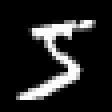
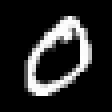
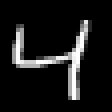
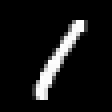
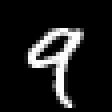

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocessing(X, y)
    Xs = Flux.flatten( Float32.(X) )
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    # add here pca and standardize ???
    
    #Xs = Flux.batch(Xs)
    #ys = Flux.batch(ys)
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocessing(trainX, trainY);

In [67]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### Exemplo preliminar DNN

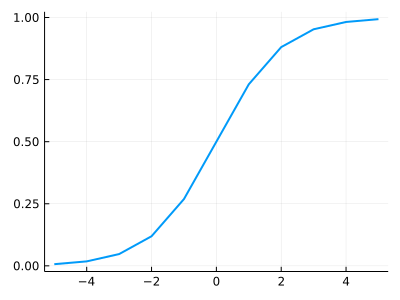

In [7]:
# built-in sigmoid function
plot(-5:5, σ.(-5:5), size=(400,300), linewidth=2, legend=false)

In [45]:
model = Chain( Flux.Dense(d, 10, identity), softmax)

losses(X, y)    = Flux.crossentropy( model(X), y )
modelParameters = Flux.params(model)
dataLoader      = Flux.DataLoader((X, y))


Flux.Data.DataLoader{Tuple{Matrix{Float32}, Flux.OneHotArray{UInt32, 10, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 1 0 … 0 0; 0 0 … 0 0]), 1, 42001, true, 42001, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  41992, 41993, 41994, 41995, 41996, 41997, 41998, 41999, 42000, 42001], false, Random._GLOBAL_RNG())

In [84]:
# single epoch
@time Flux.train!(losses, modelParameters, dataLoader, Descent())
@time Flux.@epochs 100 Flux.train!(losses, modelParameters, dataLoader, Descent());

  4.108260 seconds (8.48 M allocations: 2.042 GiB, 3.83% gc time)


┌ Info: Epoch 1
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 2
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 3
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 4
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 5
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 6
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 7
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 8
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 9
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 10
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 11
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 12
└ 

┌ Info: Epoch 93
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 94
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 95
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 96
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 97
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 98
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 99
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143
┌ Info: Epoch 100
└ @ Main /home/ciro/.julia/packages/Flux/qAdFM/src/optimise/train.jl:143


402.178230 seconds (848.43 M allocations: 204.157 GiB, 3.00% gc time)


In [85]:
ŷ = [findmax(model(X[:,i]))[2] for i in 1:N];

In [86]:
printMetrics(ŷ .- 1, trainY)

10×10 Matrix{Int64}:
 4064     2    21     6     7    24    10     4     9    16
    0  4523     8     7     6     4     0     2    11     3
    6    42  3882    75    23    25     7    28    29     2
    0    17    46  3858     1    56     0     4    24    20
    6     3    22     5  3747    22     5    29     4    54
    5     6     6   117     1  3371    12     1    51     9
   33    12    54    28    65    96  4091     4    19     4
    7    14    34    46    27    17     2  4207    14   164
   21    92    86    92    38   136    14     8  3875    27
    4     8    12    58   174    44     2    99    60  3865

accuracy: 0.94
f1-score: 0.939


┌ Warning: The classes are un-ordered,
│ using order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/measures/confusion_matrix.jl:118
